In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
import seaborn as sns
from matplotlib.pylab import rcParams
from matplotlib.lines import Line2D

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

# Functions

In [2]:
def get_datetimes(df, n):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[n:], format='%Y-%m')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'Zipcode', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Importing Data

From the zillow website, we imported the home value data.

In [4]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,329121.0,334059.0,338019.0,346657.0,354457.0,361917.0,369769.0,376112.0,381673.0,386586.0,394154.0,402687.0,412006.0,420541.0,429242.0,436291.0,442139.0,447655.0,452725.0,457455.0,461020.0,465658.0,469811.0,475268.0,478912.0,482464.0,484481.0,488259.0,493127.0,499165.0,503717.0,507932.0,511068.0,514280.0,518252.0,522487.0,527352.0,531284.0,535317.0,539349.0,549450.0,567133.0,588505.0,605851.0,613242.0,617110.0,619549.0,625388.0,631255.0,636089.0,639742.0,643306.0,647193.0,652314.0,659961.0,669842.0,683972.0,696806.0,708743.0,716797.0,728843.0,739511.0,759399.0,771571.0,785979.0,795559.0,805064.0,814587.0,817033.0,832764.0,850933.0,876511.0,901911.0,921178.0,927869.0,922251.0,924475.0,931610.0,934145.0,909286.0,874103.0,840213.0,841253.0,864029.0,878088.0,880955.0,875206.0,881249.0,884836.0,877242.0,872894.0,865069.0,888219.0,909058.0,932691.0,932638.0,933780.0,929386.0,935242.0,949011.0,950769.0,940471.0,901618.0,887671.0,894583.0,898397.0,891086.0,854973.0,823871.0,7

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30523 entries, 0 to 30522
Columns: 269 entries, RegionID to 2021-08-31
dtypes: float64(260), int64(3), object(6)
memory usage: 62.6+ MB


The dataset has 30,523 rows and 269 columns.

# Data Cleaning/Visualization

First, we changed RegionName feature name to Zipcode for easier read.

In [6]:
df = df.rename(columns={'RegionName': 'Zipcode'})

We will visualize median home values per state.

In [7]:
new_df = pd.DataFrame()

# Pull the median and mean house price values by state from January 2019:
new_df['January_2019_Median']= df.groupby('State').median()['2019-01-31']

new_df['January_2019_mean'] = df.groupby('State').mean()['2019-01-31']

In [8]:
new_df.head()

,January_2019_Median,January_2019_mean
State,,
AK,240656.5,244276.083333
AL,109846.0,126464.393673
AR,84655.0,94883.126143
AZ,225144.0,246414.560472
CA,478342.0,625583.196799


Maximum median : 682497.1739130435
Maximum mean : 190265.94346289753


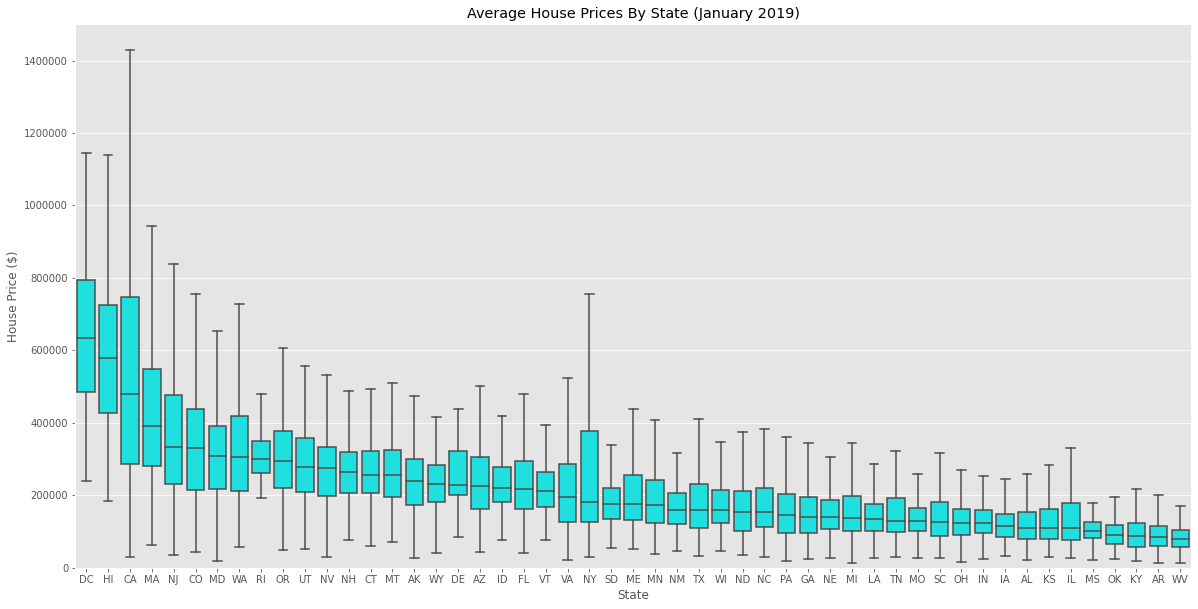

In [9]:
plt.figure(figsize=(20,10))

# Collect most recent data from January 2019:
y = '2019-01-31'

# Put states in alphabetical order:
state_order = new_df['January_2019_Median'].sort_values(ascending=False).index



# Create a boxplot for each state:
sns.boxplot(x='State',y=y,
            data=df,order=state_order,
            showfliers=False, color = 'Aqua')

# Set labels and axis limits:
plt.ylim(0,);
plt.xlabel('State')
plt.ylabel('House Price ($)')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Average House Prices By State (January 2019)');

# Print maximum mean and median value
print('Maximum median',':',df.groupby('State').mean()['2019-01-31'].max())
print('Maximum mean',':',df.groupby('State').mean()['2019-01-31'].median())

Since our stakeholder is looking for north-eastern area, we are going to take data from only NY, NJ, PA, MA, and CT states.

In [10]:
df = df[df['State'].isin(['NY', 'NJ', 'PA', 'MA', 'CT'])]
df.head()

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,329121.0,334059.0,338019.0,346657.0,354457.0,361917.0,369769.0,376112.0,381673.0,386586.0,394154.0,402687.0,412006.0,420541.0,429242.0,436291.0,442139.0,447655.0,452725.0,457455.0,461020.0,465658.0,469811.0,475268.0,478912.0,482464.0,484481.0,488259.0,493127.0,499165.0,503717.0,507932.0,511068.0,514280.0,518252.0,522487.0,527352.0,531284.0,535317.0,539349.0,549450.0,567133.0,588505.0,605851.0,613242.0,617110.0,619549.0,625388.0,631255.0,636089.0,639742.0,643306.0,647193.0,652314.0,659961.0,669842.0,683972.0,696806.0,708743.0,716797.0,728843.0,739511.0,759399.0,771571.0,785979.0,795559.0,805064.0,814587.0,817033.0,832764.0,850933.0,876511.0,901911.0,921178.0,927869.0,922251.0,924475.0,931610.0,934145.0,909286.0,874103.0,840213.0,841253.0,864029.0,878088.0,880955.0,875206.0,881249.0,884836.0,877242.0,872894.0,865069.0,888219.0,909058.0,932691.0,932638.0,933780.0,929386.0,935242.0,949011.0,950769.0,940471.0,901618.0,887671.0,894583.0,898397.0,891086.0,854973.0,823871.0,7930

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4884 entries, 0 to 30522
Columns: 269 entries, RegionID to 2021-08-31
dtypes: float64(260), int64(3), object(6)
memory usage: 10.1+ MB


Now we have 4,884 rows of data.

We are going to create a new dataframe with just the home values.

In [12]:
zipcode_df = df.loc[:, df.columns[9:]]
zipcode_df.head()

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
0,329121.0,334059.0,338019.0,346657.0,354457.0,361917.0,369769.0,376112.0,381673.0,386586.0,394154.0,402687.0,412006.0,420541.0,429242.0,436291.0,442139.0,447655.0,452725.0,457455.0,461020.0,465658.0,469811.0,475268.0,478912.0,482464.0,484481.0,488259.0,493127.0,499165.0,503717.0,507932.0,511068.0,514280.0,518252.0,522487.0,527352.0,531284.0,535317.0,539349.0,549450.0,567133.0,588505.0,605851.0,613242.0,617110.0,619549.0,625388.0,631255.0,636089.0,639742.0,643306.0,647193.0,652314.0,659961.0,669842.0,683972.0,696806.0,708743.0,716797.0,728843.0,739511.0,759399.0,771571.0,785979.0,795559.0,805064.0,814587.0,817033.0,832764.0,850933.0,876511.0,901911.0,921178.0,927869.0,922251.0,924475.0,931610.0,934145.0,909286.0,874103.0,840213.0,841253.0,864029.0,878088.0,880955.0,875206.0,881249.0,884836.0,877242.0,872894.0,865069.0,888219.0,909058.0,932691.0,932638.0,933780.0,929386.0,935242.0,949011.0,950769.0,940471.0,901618.0,887671.0,894583.0,898397.0,891086.0,854973.0,823871.0,793092.0,777779.0,766525.0,772543.0,770780.0,773305.0,756324.0,737652.0,722210.0,713278.0,703950.0,697043.0,692785.0,693089.0,697906.0,697627.0,700429.0,707

We are going to set our index names to our zipcodes so it is easier for us to identify each row.

In [13]:
zipcode_df.index = df['Zipcode']

In [14]:
zipcode_df.columns = get_datetimes(zipcode_df, 0)
zipcode_df.head()

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10025,329121.0,334059.0,338019.0,346657.0,354457.0,361917.0,369769.0,376112.0,381673.0,386586.0,394154.0,402687.0,412006.0,420541.0,429242.0,436291.0,442139.0,447655.0,452725.0,457455.0,461020.0,465658.0,469811.0,475268.0,478912.0,482464.0,484481.0,488259.0,493127.0,499165.0,503717.0,507932.0,511068.0,514280.0,518252.0,522487.0,527352.0,531284.0,535317.0,539349.0,549450.0,567133.0,588505.0,605851.0,613242.0,617110.0,619549.0,625388.0,631255.0,636089.0,639742.0,643306.0,647193.0,652314.0,659961.0,669842.0,683972.0,696806.0,708743.0,716797.0,728843.0,739511.0,759399.0,771571.0,785979.0,795559.0,805064.0,814587.0,817033.0,832764.0,850933.0,876511.0,901911.0,921178.0,927869.0,922251.0,924475.0,931610.0,934145.0,909286.0,874103.0,840213.0,841253.0,864029.0,878088.0,880955.0,875206.0,881249.0,884836.0,877242.0,872894.0,865069.0,888219.0,909058.0,932691.0,932638.0,9

We want to resample our data to yearly value. So we are going to transpose our dataframe to make the dates be the index.

In [15]:
zipcode_df = zipcode_df.T
zipcode_df.head()

Zipcode        10025     10023     10002     11226     10467     10016  \
2000-01-31  329121.0  500887.0  437758.0  264706.0  155345.0  306605.0   
2000-02-29  334059.0  504739.0  432015.0  266665.0  156677.0  309729.0   
2000-03-31  338019.0  507445.0  432238.0  267998.0  157749.0  312351.0   
2000-04-30  346657.0  514136.0  430229.0  270531.0  160267.0  317572.0   
2000-05-31  354457.0  522082.0  435590.0  273022.0  162638.0  322494.0   

Zipcode        11201     11235     11375     10029     10009     10011  \
2000-01-31  297570.0  196497.0  327616.0       NaN  427019.0  705721.0   
2000-02-29  298457.0  197210.0  329936.0  250337.0  415842.0  712981.0   
2000-03-31  300861.0  198764.0  332289.0  252106.0  410763.0  719583.0   
2000-04-30  303995.0  202062.0  335736.0  254601.0  400959.0  730390.0   
2000-05-31  307977.0  205722.0  338312.0  258671.0  399539.0  741985.0   

Zipcode        10128     11206    10462     10456     10019     10003  \
2000-01-31  492013.0  239970.0  73911.0  170096.0  468142.0  434307.0   
2000-02-29  493943.0  242191.0  74114.0  178002.0  473066.0  440338.0   
2000-03-31  496646.0  244171.0  74543.0  181364.0  476615.0  444780.0   
2000-04-30  503125.0  248256.0  75078.0  186548.0  484130.0  454573.0   
2000-05-31  512965.0  253438.0  75779.0  187398.0  491405.0  462801.0   

Zipcode        11230     11212     10463     11209     11221     7030   \
2000-01-31  285085.0  200808.0  189279.0  325638.0  217821.0  249939.0   
2000-02-29  287111.0  201731.0  192449.0  328063.0  219343.0  251278.0   
2000-03-31  289574.0  202488.0  193183.0  330448.0  220542.0  253025.0   
2000-04-30  294339.0  203795.0  196218.0  334892.0  223274.0  256690.0   
2000-05-31  298807.0  205184.0  197926.0  339684.0  225541.0  260642.0   

Zipcode        10024     8701      11214     11207     2169      11229  \
2000-01-31  473591.0  170638.0  210174.0  166912.0  188480.0  194857.0   
2000-02-29  479599.0  171545.0  211608.0  167628.0  189301.0  196373.0   
2000-03-31  483744.0  172055.0  212955.0  168301.0  190217.0  197784.0   
2000-04-30  495437.0  173434.0  215562.0  170072.0  192377.0  200503.0   
2000-05-31  507065.0  174753.0  217674.0  171716.0  195766.0  202944.0   

Zipcode        10458     11211     11377     10453     7302      11234  \
2000-01-31  187731.0  196111.0  260725.0  181349.0  195835.0  243812.0   
2000-02-29  188044.0  197295.0  262508.0  181888.0  196933.0  246038.0   
2000-03-31  188431.0  196846.0  264548.0  183451.0  197935.0  247777.0   
2000-04-30  189668.0  197982.0  266744.0  186118.0  199587.0  251252.0   
2000-05-31  191811.0  198907.0  268561.0  188511.0  201210.0  254065.0   

Zipcode        11355     11238     10314    19143     11215     10452  \
2000-01-31  223427.0  232535.0  182419.0  61158.0  331330.0  262889.0   
2000-02-29  225000.0  233791.0  183747.0  61467.0  334148.0  269926.0   
2000-03-31  227015.0  234621.0  184789.0  61591.0  338027.0  274419.0   
2000-04-30  229568.0  238739.0  186981.0  61959.0  347213.0  278054.0   
2000-05-31  231972.0  242641.0  189131.0  62556.0  355720.0  279088.0   

Zipcode        6010   17603     14850     11385     2148   15601    6902   \
2000-01-31  136149.0    NaN  109944.0  273262.0  190640.0    NaN  94304.0   
2000-02-29  136219.0    NaN  110597.0  275115.0  191565.0    NaN  95264.0   
2000-03-31  137059.0    NaN  111019.0  277043.0  192865.0    NaN  95881.0   
2000-04-30  138511.0    NaN  111930.0  279488.0  195132.0    NaN  97011.0   
2000-05-31  139294.0    NaN  112634.0  280882.0  197692.0    NaN  97891.0   

Zipcode        10468     11373     8753      10028     11233     7002   \
2000-01-31  116883.0  205902.0  142597.0  445266.0  172442.0  171166.0   
2000-02-29  116798.0  207276.0  143398.0  449673.0  174109.0  172197.0   
2000-03-31  117703.0  208657.0  143816.0  453121.0  175819.0  173243.0   
2000-04-30  119274.0  211023.0  144843.0  460820.0  178216.0  174896.0   
2000-05-31  121009.0  213173.0  145563.0  469367.0  180092.0  17

Let's pick some zipcodes and visualize the data.

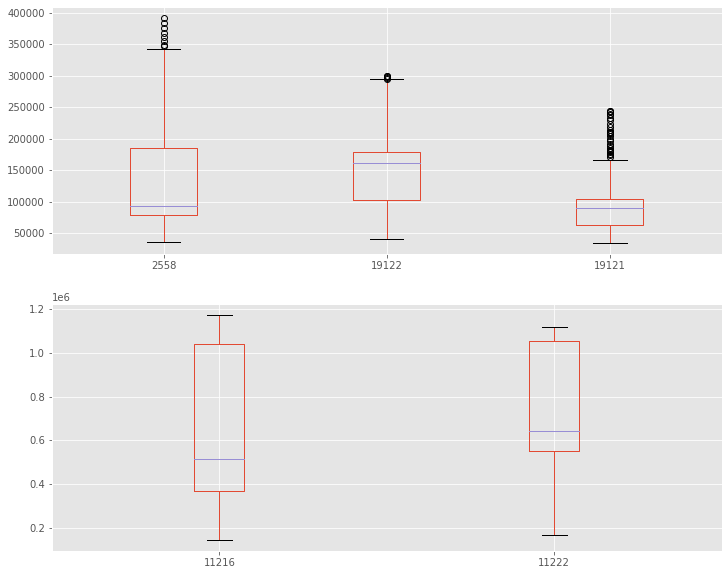

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
zipcode_df[[2558, 19122, 19121]].boxplot(ax=ax[0])
zipcode_df[[11216, 11222]].boxplot(ax=ax[1]);

Now, let's resample home values by year by taking the average of each year.

In [17]:
zipcode_df = zipcode_df.resample('A').mean()
zipcode_df.head()

Zipcode             10025          10023          10002          11226  \
2000-12-31  364600.916667  537906.583333  438984.750000  275972.833333   
2001-12-31  447484.250000  636834.166667  498103.500000  307207.833333   
2002-12-31  500345.333333  716431.416667  586745.666667  316608.250000   
2003-12-31  576627.500000  809314.166667  673998.333333  357620.250000   
2004-12-31  665501.666667  915925.083333  769481.500000  370821.750000   

Zipcode             10467          10016          11201          11235  \
2000-12-31  164823.666667  328978.833333  322206.000000  208098.416667   
2001-12-31  180623.500000  395332.083333  417565.916667  242964.833333   
2002-12-31  197992.916667  444675.083333  517040.916667  264738.416667   
2003-12-31  211694.583333  510676.500000  631290.750000  307811.916667   
2004-12-31  233207.333333  591005.666667  702087.916667  359351.000000   

Zipcode             11375          10029          10009         10011  \
2000-12-31  344861.333333  265611.090909  404363.416667  7.548758e+05   
2001-12-31  388981.666667  316709.916667  475294.833333  8.902272e+05   
2002-12-31  409970.666667  344068.000000  596817.833333  1.023533e+06   
2003-12-31  431830.083333  397041.833333  671949.083333  1.136206e+06   
2004-12-31  457764.666667  480039.833333  760008.500000  1.245471e+06   

Zipcode             10128          11206          10462          10456  \
2000-12-31  526289.500000  262318.250000   77067.333333  186652.666667   
2001-12-31  620255.416667  304764.083333   88674.250000  182457.750000   
2002-12-31  638802.166667  376938.250000   89479.666667  193704.666667   
2003-12-31  696030.833333  441786.416667   96310.916667  210815.500000   
2004-12-31  787047.250000  465449.083333  107587.833333  245143.000000   

Zipcode             10019          10003      11230          11212  \
2000-12-31  504075.833333  470970.750000  302907.50  208247.083333   
2001-12-31  600374.416667  556581.416667  353115.25  213274.416667   
2002-12-31  686741.833333  615307.083333  425609.25  231486.916667   
2003-12-31  788240.000000  713351.916667  505764.00  262651.000000   
2004-12-31  909877.250000  847839.416667  557973.50  286255.250000   

Zipcode             10463          11209          11221          7030   \
2000-12-31  202187.416667  343250.833333  229015.000000  265424.083333   
2001-12-31  226877.250000  381280.000000  255960.083333  305161.916667   
2002-12-31  235068.250000  397264.583333  275037.916667  344213.416667   
2003-12-31  255640.083333  457404.833333  323797.416667  370008.916667   
2004-12-31  303963.666667  506443.416667  374734.000000  407712.500000   

Zipcode             10024          8701           11214          11207  \
2000-12-31  519826.750000  177716.500000  219803.500000  174242.333333   
2001-12-31  613723.583333  199592.166667  242499.500000  187913.333333   
2002-12-31  701163.083333  229280.833333  259669.833333  201384.750000   
2003-12-31  791054.916667  279816.666667  311317.166667  229788.750000   
2004-12-31  893582.833333  327002.416667  355780.500000  243255.416667   

Zipcode             2169           11229          10458          11211  \
2000-12-31  202178.083333  206328.500000  194571.250000  208199.083333   
2001-12-31  243157.500000  237274.916667  208093.083333  265819.583333   
2002-12-31  280047.666667  272336.750000  229416.000000  338415.583333   
2003-12-31  319887.833333  337403.666667  251251.000000  401118.250000   
2004-12-31  350725.666667  404194.250000  298777.916667  443505.750000   

Zipcode             11377          10453          7302           11234  \
2000-12-31  272833.000000  190985.916667  206443.833333  257001.333333   
2001-12-31  309542.750000  197902.833333  255604.250000  281695.250000   
2002-12-31  325804.333333  205589.500000  306144.083333  297717.333333   
2003-12-31  351953.000000  220969.000000  338095.083333  357141.083333   
2004-12-31  397145.666667  235083.666667  382297.000000  414734.916667   

Zipcode             11355

Now, let's transpose the dataframe back.

In [18]:
zipcode_df = zipcode_df.T
zipcode_df.head()

,2000-12-31,2001-12-31,2002-12-31,2003-12-31,2004-12-31,2005-12-31,2006-12-31,2007-12-31,2008-12-31,2009-12-31,2010-12-31,2011-12-31,2012-12-31,2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31
Zipcode,,,,,,,,,,,,,,,,,,,,,,
10025,364600.916667,447484.250000,500345.333333,576627.500000,665501.666667,7.981462e+05,8.993602e+05,8.898454e+05,9.139156e+05,7.592758e+05,709883.916667,740445.500000,7.531898e+05,8.036307e+05,9.132885e+05,9.817538e+05,1.039384e+06,1.039147e+06,1.057255e+06,1.086893e+06,1.051246e+06,1114518.875
10023,537906.583333,636834.166667,716431.416667,809314.166667,915925.083333,1.078528e+06,1.206610e+06,1.207426e+06,1.272393e+06,1.021550e+06,938849.000000,997383.166667,1.034857e+06,1.103962e+06,1.243271e+06,1.321928e+06,1.392055e+06,1.422695e+06,1.505360e+06,1.419982e+06,1.471571e+06,1456762.750
10002,438984.750000,498103.500000,586745.666667,673998.333333,769481.500000,8.964938e+05,1.019136e+06,1.001938e+06,9.936774e+05,8.512638e+05,787747.416667,827789.666667,8.437419e+05,9.052522e+05,9.944523e+05,1.074337e+06,1.040234e+06,9.663266e+05,9.109255e+05,1.007627e+06,1.021829e+06,877680.000
11226,275972.833333,307207.833333,316608.250000,357620.250000,370821.750000,4.504902e+05,5.297782e+05,5.752878e+05,5.702421e+05,5.081583e+05,487055.833333,478732.166667,4.937723e+05,5.175646e+05,5.634913e+05,6.401825e+05,6.948982e+05,7.483428e+05,7.768873e+05,8.241271e+05,7.924181e+05,802142.625
10467,164823.666667,180623.500000,197992.916667,211694.583333,233207.333333,2.750774e+05,3.170824e+05,3.465273e+05,3.390513e+05,2.927356e+05,281392.500000,275008.250000,2.704657e+05,2.781789e+05,2.906831e+05,3.086776e+05,3.177903e+05,3.493210e+05,3.882428e+05,4.227451e+05,4.432446e+05,465834.500


To figure out which zipcodes are the best to invest in, we are going to calculate the return rate per year.

In [19]:
zipcode_df['return_rate'] = ((zipcode_df['2021-12-31'] - zipcode_df['2000-12-31']) / zipcode_df['2000-12-31'])*100
zipcode_df['return_rate_per_year'] = zipcode_df['return_rate']/21
zipcode_df.head()

,2000-12-31 00:00:00,2001-12-31 00:00:00,2002-12-31 00:00:00,2003-12-31 00:00:00,2004-12-31 00:00:00,2005-12-31 00:00:00,2006-12-31 00:00:00,2007-12-31 00:00:00,2008-12-31 00:00:00,2009-12-31 00:00:00,2010-12-31 00:00:00,2011-12-31 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00,2018-12-31 00:00:00,2019-12-31 00:00:00,2020-12-31 00:00:00,2021-12-31 00:00:00,return_rate,return_rate_per_year
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,
10025,364600.916667,447484.250000,500345.333333,576627.500000,665501.666667,7.981462e+05,8.993602e+05,8.898454e+05,9.139156e+05,7.592758e+05,709883.916667,740445.500000,7.531898e+05,8.036307e+05,9.132885e+05,9.817538e+05,1.039384e+06,1.039147e+06,1.057255e+06,1.086893e+06,1.051246e+06,1114518.875,205.681863,9.794374
10023,537906.583333,636834.166667,716431.416667,809314.166667,915925.083333,1.078528e+06,1.206610e+06,1.207426e+06,1.272393e+06,1.021550e+06,938849.000000,997383.166667,1.034857e+06,1.103962e+06,1.243271e+06,1.321928e+06,1.392055e+06,1.422695e+06,1.505360e+06,1.419982e+06,1.471571e+06,1456762.750,170.820770,8.134322
10002,438984.750000,498103.500000,586745.666667,673998.333333,769481.500000,8.964938e+05,1.019136e+06,1.001938e+06,9.936774e+05,8.512638e+05,787747.416667,827789.666667,8.437419e+05,9.052522e+05,9.944523e+05,1.074337e+06,1.040234e+06,9.663266e+05,9.109255e+05,1.007627e+06,1.021829e+06,877680.000,99.934052,4.758764
11226,275972.833333,307207.833333,316608.250000,357620.250000,370821.750000,4.504902e+05,5.297782e+05,5.752878e+05,5.702421e+05,5.081583e+05,487055.833333,478732.166667,4.937723e+05,5.175646e+05,5.634913e+05,6.401825e+05,6.948982e+05,7.483428e+05,7.768873e+05,8.241271e+05,7.924181e+05,802142.625,190.659996,9.079047
10467,164823.666667,180623.500000,197992.916667,211694.583333,233207.333333,2.750774e+05,3.170824e+05,3.465273e+05,3.390513e+05,2.927356e+05,281392.500000,275008.250000,2.704657e+05,2.781789e+05,2.906831e+05,3.086776e+05,3.177903e+05,3.493210e+05,3.882428e+05,4.227451e+05,4.432446e+05,465834.500,182.625978,8.696475


With the return rate per year, we are going to pick the top 5 highest return rate.

In [20]:
zipcode_df.sort_values(by='return_rate_per_year', ascending=False).head(5)

,2000-12-31 00:00:00,2001-12-31 00:00:00,2002-12-31 00:00:00,2003-12-31 00:00:00,2004-12-31 00:00:00,2005-12-31 00:00:00,2006-12-31 00:00:00,2007-12-31 00:00:00,2008-12-31 00:00:00,2009-12-31 00:00:00,2010-12-31 00:00:00,2011-12-31 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00,2018-12-31 00:00:00,2019-12-31 00:00:00,2020-12-31 00:00:00,2021-12-31 00:00:00,return_rate,return_rate_per_year
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,
2558,36964.416667,46860.750000,58951.166667,73839.583333,81465.333333,91191.083333,98618.500000,90287.416667,90895.416667,81423.500000,81278.916667,81293.000000,84706.583333,109882.416667,136346.750000,1.623931e+05,1.896925e+05,2.189622e+05,2.584022e+05,2.676696e+05,3.246265e+05,366638.625,891.869095,42.469957
11216,158479.416667,186038.166667,220661.500000,268010.916667,313416.416667,377583.333333,460031.750000,522687.083333,541119.583333,471203.166667,456315.666667,465404.083333,507982.166667,613773.833333,814626.583333,9.696168e+05,1.058784e+06,1.076584e+06,1.145235e+06,1.144215e+06,1.145505e+06,1152785.125,627.403690,29.876366
19122,43073.250000,49257.500000,60191.916667,73493.833333,92622.500000,107774.916667,136895.916667,160958.416667,155417.500000,164019.416667,167015.916667,158536.416667,145589.583333,161409.416667,167096.083333,1.783024e+05,1.789871e+05,2.031756e+05,2.369558e+05,2.594141e+05,2.750910e+05,295731.375,586.577806,27.932276
19121,36127.500000,41512.083333,42839.500000,47378.500000,58035.166667,77900.916667,97453.083333,113018.166667,103451.750000,100302.583333,93118.083333,79137.750000,62845.750000,73558.916667,81038.500000,9.014233e+04,9.106808e+04,1.119107e+05,1.495841e+05,1.782407e+05,2.029722e+05,236809.125,555.481628,26.451506
11222,178506.583333,222675.416667,298888.750000,360174.833333,421157.666667,573325.750000,654414.833333,663559.750000,641443.416667,582575.250000,563242.000000,573196.083333,618760.000000,737275.833333,876103.333333,1.011760e+06,1.054034e+06,1.063602e+06,1.078892e+06,1.085332e+06,1.087756e+06,1096991.500,514.538399,24.501829


In [21]:
zipcode_df.sort_values(by='return_rate_per_year', ascending=False).head(5).index

Int64Index([2558, 11216, 19122, 19121, 11222], dtype='int64', name='Zipcode')

We found that zipcodes 2558, 11216, 19122, 19121, 11222 are the best areas to invest in.

- Zipcode 02558 has 42.5% annual average return rate.
- Zipcode 11216 has 29.9% annual average return rate.
- Zipcode 19122 has 27.9% annual average return rate.
- Zipcode 19121 has 26.5% annual average return rate.
- Zipcode 11222 has 24.5% annual average return rate.

Now, let's create a new dataframe with just the 5 zipcodes.

In [22]:
top_five_df = df[df['Zipcode'].isin([2558, 11216, 19122, 19121, 11222])]
top_five_df

,RegionID,SizeRank,Zipcode,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
513,62027,516,11216,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,146780.0,147714.0,149286.0,152704.0,155479.0,157950.0,159636.0,161633.0,163728.0,166215.0,169095.0,171533.0,174179.0,176378.0,179995.0,182328.0,185189.0,186919.0,188863.0,190017.0,190920.0,191661.0,192607.0,193402.0,196350.0,202319.0,209386.0,214557.0,216980.0,218140.0,219961.0,225423.0,231151.0,236091.0,237881.0,239699.0,241739.0,247797.0,255283.0,263500.0,269034.0,274149.0,278532.0,278138.0,277799.0,274600.0,276601.0,278959.0,288310.0,295481.0,299891.0,300017.0,301024.0,303877.0,310671.0,316368.0,325906.0,332447.0,341614.0,345391.0,345270.0,344308.0,347635.0,354507.0,362819.0,370998.0,380269.0,388377.0,395615.0,405160.0,413181.0,422861.0,431253.0,438245.0,437856.0,438871.0,440585.0,451278.0,459918.0,472555.0,476359.0,485070.0,490429.0,497962.0,503509.0,505486.0,513060.0,515697.0,519969.0,519200.0,522359.0,528713.0,531680.0,534140.0,536470.0,541962.0,549921.0,555714.0,560558.0,556901.0,552601.0,547517.0,543079.0,536365.0,529459.0,522637.0,520122.0,518561.0,513747.0,506

With the melt function, we are going to create 5 dataframs with just the home values.

In [23]:
df_2558 = melt_data(top_five_df[top_five_df['Zipcode'] == 2558])
df_11216 = melt_data(top_five_df[top_five_df['Zipcode'] == 11216])
df_19122 = melt_data(top_five_df[top_five_df['Zipcode'] == 19122])
df_19121 = melt_data(top_five_df[top_five_df['Zipcode'] == 19121])
df_11222 = melt_data(top_five_df[top_five_df['Zipcode'] == 11222])

Let's try to visualize our melted dataframe

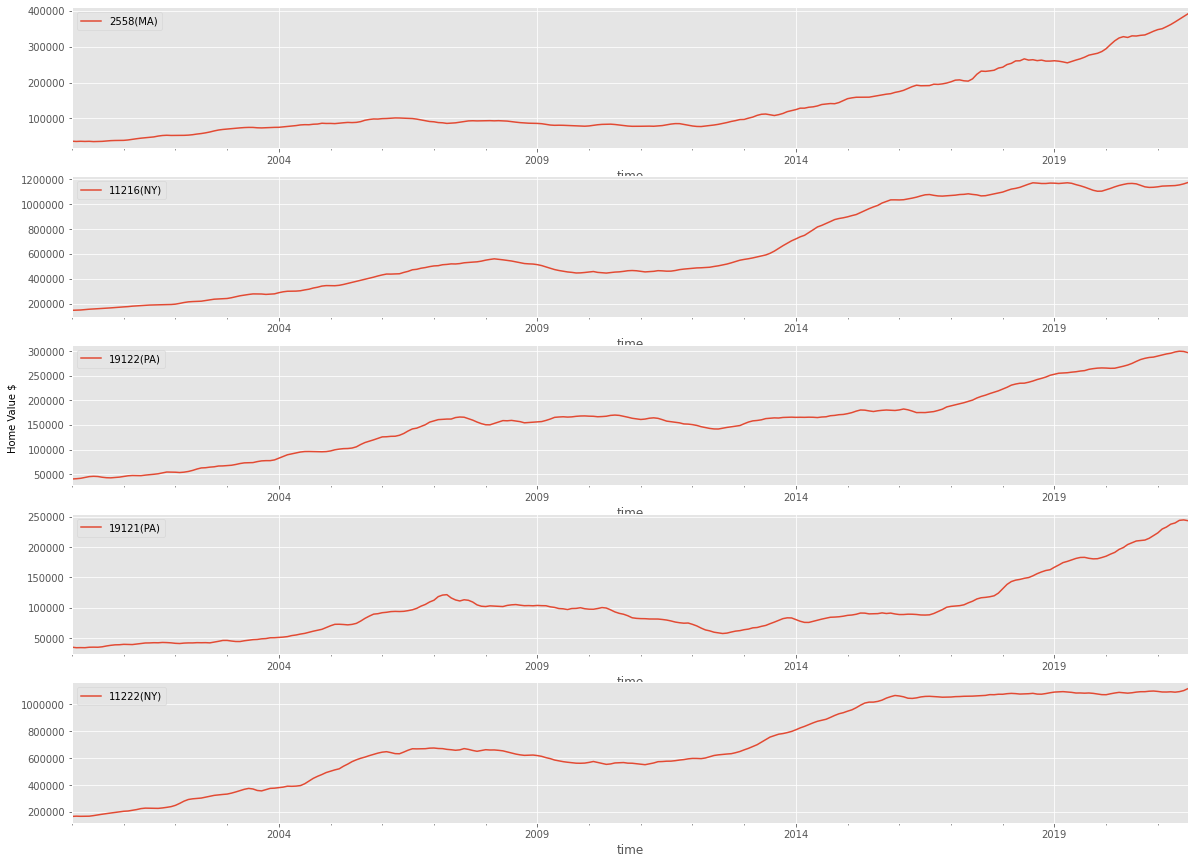

In [24]:
fig, ax = plt.subplots(5,1,figsize=(20,15))

df_2558.plot(ax=ax[0])
ax[0].legend(['2558(MA)'])
ax[0].ticklabel_format(useOffset=False, style='plain', axis='y')

df_11216.plot(ax=ax[1])
ax[1].legend(['11216(NY)'])
ax[1].ticklabel_format(useOffset=False, style='plain', axis='y')

df_19122.plot(ax=ax[2])
ax[2].legend(['19122(PA)'])
ax[2].ticklabel_format(useOffset=False, style='plain', axis='y')

df_19121.plot(ax=ax[3])
ax[3].legend(['19121(PA)'])
ax[3].ticklabel_format(useOffset=False, style='plain', axis='y')

df_11222.plot(ax=ax[4])
ax[4].legend(['11222(NY)'])
ax[4].ticklabel_format(useOffset=False, style='plain', axis='y')

fig.text(0.08, 0.5, 'Home Value $', va='center', rotation='vertical');

With the top 5 zip codes we found above, we will forecast future home values in separate notebooks:

- [Zip Code 02558](Zipcode_02558.ipynb)
- [Zip Code 11216](Zipcode_11216.ipynb)
- [Zip Code 19122](Zipcode_19122.ipynb)
- [Zip Code 19121](Zipcode_19121.ipynb)
- [Zip Code 11222](Zipcode_11222.ipynb)